In [6]:
import pandas as pd
import numpy as np
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import dok_matrix, csr_matrix
import networkx as nx
import pygraphviz
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from simulation.constants import *

In [13]:
def show_graph(G, labels=False):
    plt.figure(1, figsize=(12,12))
    pos = graphviz_layout(G, prog="neato")
    nx.draw(G, pos, node_size=40, vmin=0.0, vmax=1.0, with_labels=True)
    try:
        if labels:
            nx.draw_networkx_edge_labels(G, pos, edge_labels={t[:2]: int(t[2]["hops"]) for t in G.edges.data()})
    except KeyError:
        pass
    plt.show()
#     plt.savefig(f"{'-'.join(list(map(str,shortest_path)))}.png")

In [3]:
df = pd.read_csv(DATA_FOLDER / "copenhagen_interactions_distance.csv", parse_dates=["datetime"])
five_minutes = [snapshot for _, snapshot in df.resample("5T", on="datetime")]

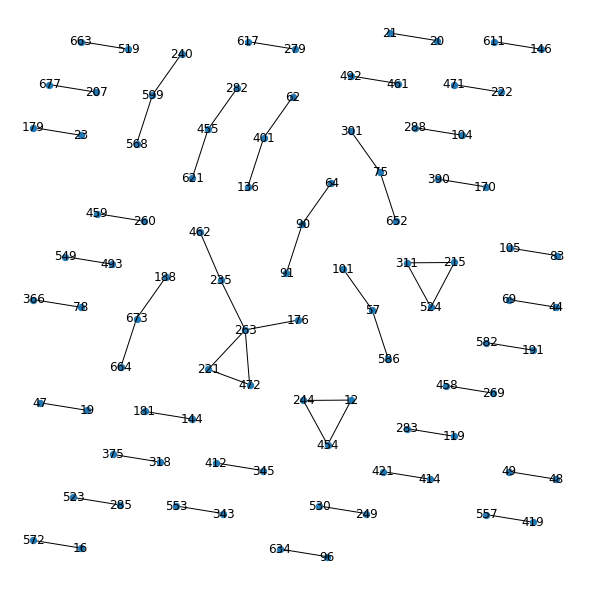

In [7]:
G = nx.from_pandas_edgelist(five_minutes[0], target="destination")
show_graph(G)

adding hops should take around 10-12 mins

In [ ]:
%%time
hops=[]
for fm in five_minutes:
    row, col = fm[["source", "destination"]].values.T
    data = [1] * len(row) 
    size = max(row+col) + 1
    graph = csr_matrix((data*2, (np.append(row,col), np.append(col,row))), shape=(size, size))
    sp = shortest_path(graph, directed=False, method="D")
    sp[sp == np.inf] = 0.
    df = pd.DataFrame({"hops": dict(dok_matrix(np.triu(sp)))}).rename_axis(["source", "destination"]).reset_index()
    df["datetime"] = fm["datetime"].iloc[0]
    hops.append(df)

cdf = pd.concat(hops)
cdf

grouping by timestamp should take around 3 mins

In [ ]:
%%time
cdf["meeting_nodes"] = cdf[["source", "destination"]].apply(lambda x: tuple(sorted(x)), axis=1)
cdf = cdf.sort_values(["meeting_nodes", "datetime"]).reset_index(drop=True)
cdf["meeting_id"] = (cdf["datetime"].diff() !=  pd.Timedelta('5m')).cumsum()
cdf = (cdf.groupby(["meeting_id","meeting_nodes", "hops"])
            .agg(**{
                "duration": pd.NamedAgg(column='datetime', aggfunc=lambda x: x.count() * 5), 
                "datetime": pd.NamedAgg(column='datetime', aggfunc='min'),
            }).reset_index()
           )
cdf[["source", "destination"]] = pd.DataFrame(cdf["meeting_nodes"].tolist())
cdf = cdf.drop(columns=["meeting_nodes", "meeting_id"])
cdf

show sample result hops

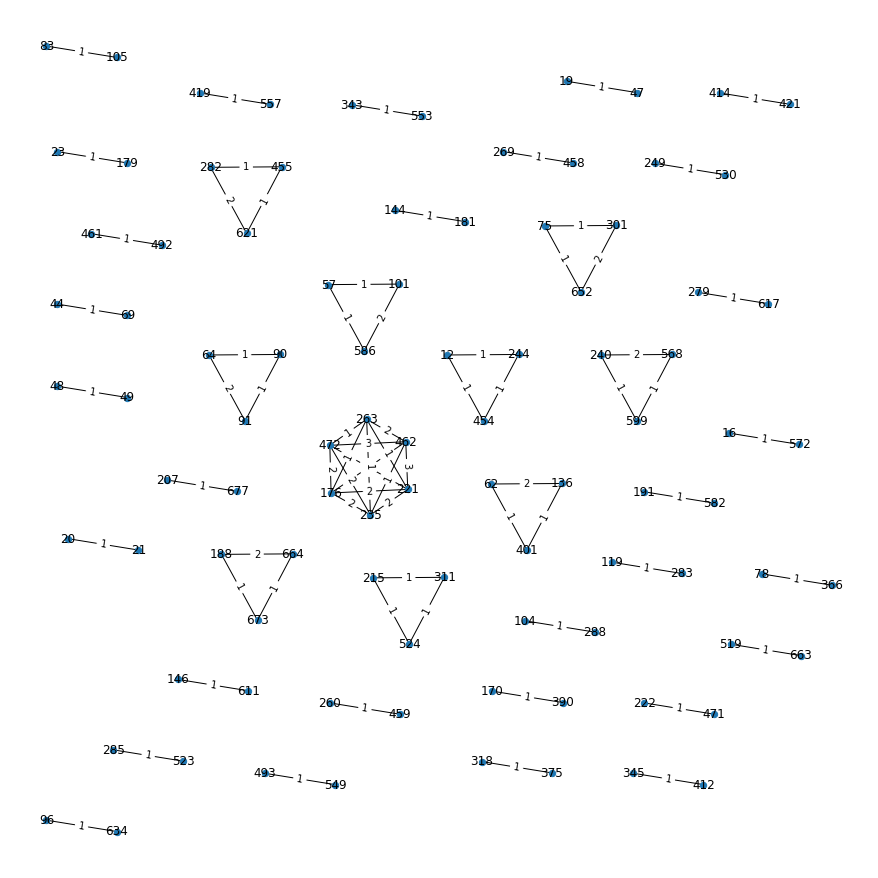

In [14]:
G = nx.from_pandas_edgelist(cdf[cdf["datetime"]==cdf["datetime"].iloc[0]], target="destination", edge_attr=True)
show_graph(G, labels=True)

In [58]:
cdf.to_csv(DATA_FOLDER / "copenhagen_hops.csv", index=False)